In [1]:
pip install langgraph langchain-openai arxiv wikipedia langchain_community Faiss-cpu

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 

In [51]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader,TextLoader, ArxivLoader
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_classic.schema import Document
from langchain_core.messages import HumanMessage, AIMessage,AnyMessage
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Sequence
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
import os
os.environ["OPENAI_API_KEY"] = "your api key"

In [4]:
docs = WebBaseLoader("https://lilianweng.github.io/posts/2024-04-12-diffusion-video/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 20)
split_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore  = FAISS.from_documents(split_docs, embedding)
retriver = vectorstore.as_retriever()

In [6]:
retriver
retriver.invoke("what are agents")

[Document(id='28d0cff5-d89e-4d66-85b5-5de39311f039', metadata={'source': 'https://lilianweng.github.io/posts/2024-04-12-diffusion-video/', 'title': "Diffusion Models for Video Generation | Lil'Log", 'description': 'Diffusion models have demonstrated strong results on image synthesis in past years. Now the research community has started working on a harder task—using it for video generation. The task itself is a superset of the image case, since an image is a video of 1 frame, and it is much more challenging because:\n\nIt has extra requirements on temporal consistency across frames in time, which naturally demands more world knowledge to be encoded into the model.\nIn comparison to text or images, it is more difficult to collect large amounts of high-quality, high-dimensional video data, let along text-video pairs.\n\n\n\n\uf8ffü•ë Required Pre-read: Please make sure you have read the previous blog on “What are Diffusion Models?” for image generation before continue here.\n', 'language

In [7]:
def retriver_tool_function(query :str)-> str:
  print("using retriver tool")
  docs = retriver.invoke(query)
  return "\n\n".join([doc.page_content for doc in docs])

In [8]:
retriver_tool_function("what are agents")

using retriver tool


'The overview of the Gen-1 model training pipeline.(Image source: Esser et al. 2023)\n\nfor object editing, background change, and style transfer.\n\nSimilar to text-to-image diffusion models, U-net and Transformer are still two common architecture choices. There are a series of diffusion video modeling papers from Google based on the U-net architecture and a recent Sora model from OpenAI leveraged the Transformer architecture.\n\nThe process of sampling a sequence of latent variables, $\\mathbf{x}^1_T, \\dots, \\mathbf{x}^m_T$, with motion information is described as follows:'

In [13]:
from langchain.tools import Tool

In [41]:
retriver_tool = Tool(
    name = "rag_retriever",
    description = "use the tool for relevant doc for user knowledge",
    func = retriver_tool_function
)

retriver_tool

Tool(name='rag_retriever', description='use the tool for relevant doc for user knowledge', func=<function retriver_tool_function at 0x79fd41d8ade0>)

In [42]:
api_wrap = ArxivAPIWrapper(top_k_results = 3,doc_content_chars_max = 4000)
Arxiv = ArxivQueryRun(api_wrapper=api_wrap)

In [43]:
api_wrap = WikipediaAPIWrapper(top_k_results = 3,doc_content_chars_max = 4000)
Wiki = WikipediaQueryRun(api_wrapper=api_wrap)


In [44]:
tools = [retriver_tool, Arxiv, Wiki]

In [45]:
llm = init_chat_model(model = "gpt-4o")

/tmp/ipython-input-2943542053.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node = create_react_agent(llm, tools)


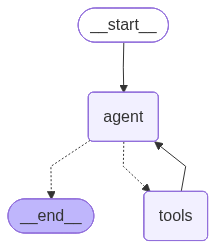

In [46]:
react_node = create_react_agent(llm, tools)
react_node

In [47]:
class Agentstate(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

In [48]:
builder = StateGraph(Agentstate)

builder.add_node("react_node", react_node)

builder.set_entry_point("react_node")
builder.add_edge("react_node", END)

graph = builder.compile()

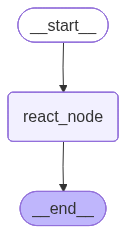

In [49]:
graph

In [50]:
if __name__ == "__main__":
  query = "tell me about agents loop"
  state = {"messages":[HumanMessage(content = query)]}
  result = graph.invoke(state)

  print("Answer is :" ,result['messages'][-1].content)

Answer is : The term "agents loop" does not have a specific Wikipedia entry. However, here are some related topics that could be of interest:

1. **Loop Diuretics**: These are agents that inhibit the Na-K-Cl cotransporter in the loop of Henle and are used to treat conditions such as hypertension and edema.

2. **Marvel's Agents of S.H.I.E.L.D.**: This is a television series based on the Marvel Comics organization S.H.I.E.L.D., featuring agents dealing with various unusual cases and enemies.

3. **Intelligent Agents in AI**: Intelligent agents perceive their environment and independently take actions to achieve goals, often improving their performance via machine learning.

If "agents loop" relates specifically to AI or computational theories, it might refer to the process of an intelligent agent's operational cycle, where it continuously perceives, decides, and acts. Let me know if you need more detailed information on any of these topics!
